Tutorial 7: Data

In this example, we’ll use the ‘imaging’ module to simulate Imaging of a strong lens made using a Tracer. By simulate, we mean that it will appear as if we had observed it using a real telescope, with this example making an image representative of Hubble Space Telescope imaging.

In [22]:
%matplotlib inline

import autolens as al
import autolens.plot as aplt
import numpy as np

To simulate an image, we need to model the telescope’s optics. We’ll do this by convolving the image with a Point-Spread Function using a Kernel object, which we can simulate as a Gaussian.

In [67]:
#Parâmetros do MGE

Surf_mge, sigma, qObs = np.loadtxt('/home/carlos/Documents/Dados Projeto/ESO325/Results/ESO325 MGE and JAM (07-07-20)/Codes/JAM Input.txt', unpack=True)

ML = 3.14
i = np.deg2rad(80)
M0 = Surf_mge*ML/1e4
M0 = M0[::-1]
q0 = np.sqrt(qObs**2 - np.cos(i)**2)/np.sin(i)
sigma0 = sigma


In [68]:
M0

array([0.17714294, 0.42711979, 1.07196422, 1.55069592, 2.07110471,
       0.78389699, 3.096937  ])

In [69]:
psf = al.Kernel.from_gaussian(shape_2d=(11, 11), sigma=0.1, pixel_scales=0.1)

To simulate Imaging dataset, we use a Grid, like usual.

In [70]:
grid = al.Grid.uniform(shape_2d=(100, 100), pixel_scales=0.1, sub_size=1)

Now, lets setup our lens galaxy, source galaxy and Tracer.

In [94]:
mass_profile = al.mp.MGE(centre=(0.0, 0.0), einstein_radius=1.6)
mass_profile.MGE_comps(M=M0, sigma=sigma0, q=q0)

lens_galaxy = al.Galaxy(
    redshift=0.5,
    mass=mass_profile,
)


source_galaxy = al.Galaxy(
    redshift=1.0,
    light=al.lp.EllipticalSersic(
        centre=(0., 0.),
        elliptical_comps=(0.3, 0.111111),
        intensity=3.0,
        effective_radius=2.0,
        sersic_index=1,
    ),
)

tracer = al.Tracer.from_galaxies(galaxies=[lens_galaxy, source_galaxy])

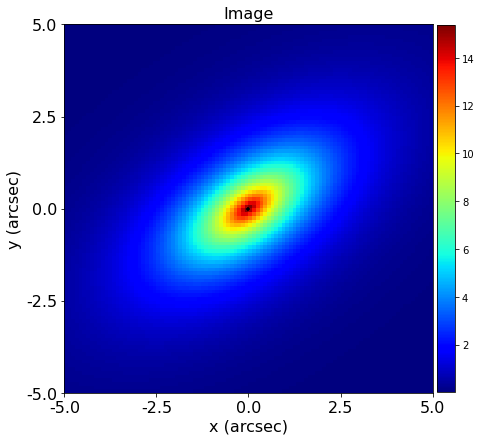

In [95]:
aplt.Galaxy.image(galaxy=source_galaxy, grid=grid)


Lets look at the Tracer’s image - this is the image we’ll be simulating.

Critical curve could not be calculated due to an unphysical mass model


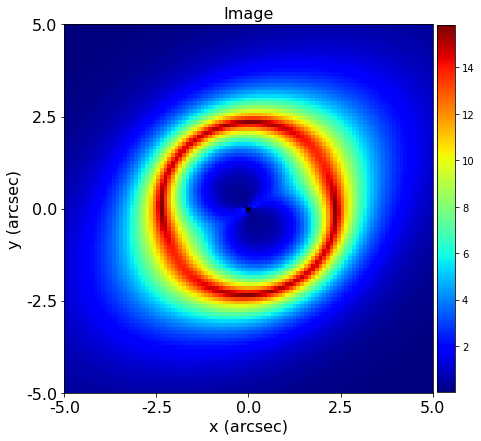

In [96]:
aplt.Tracer.image(tracer=tracer, grid=grid)

To Simulate the Imaging data, we don’t use the image plotted above. Instead, we use an image which has been generated specifically for simulating an image, which pads the array it is computed on based on the shape of the PSF we convolve the image with. This ensures edge-effects do not degrade our simulation’s PSF convolution.

In [97]:
normal_image = tracer.image_from_grid(grid=grid)
padded_image = tracer.padded_image_from_grid_and_psf_shape(
    grid=grid, psf_shape_2d=psf.shape_2d
)
print(normal_image.shape)
print(padded_image.shape)

(10000,)
(12100,)


Now, to simulate the Imaging data, we pass the Tracer and Grid to the Imaging module’s simulate function. This adds the following effects to the image:


    Telescope optics: Using the Point Spread Function above.
    The Background Sky: Although the image that is returned is automatically background sky subtracted.
    Poisson noise: Due to the background sky, lens galaxy and source galaxy Poisson photon counts.


In [98]:
simulator = al.SimulatorImaging(
    exposure_time_map=al.Array.full(fill_value=300.0, shape_2d=grid.shape_2d),
    psf=psf,
    background_sky_map=al.Array.full(fill_value=0.1, shape_2d=grid.shape_2d),
    add_noise=True,
)

imaging = simulator.from_tracer_and_grid(tracer=tracer, grid=grid)

Lets plot the image - we can see the image has been blurred due to the telescope optics and noise has been added.

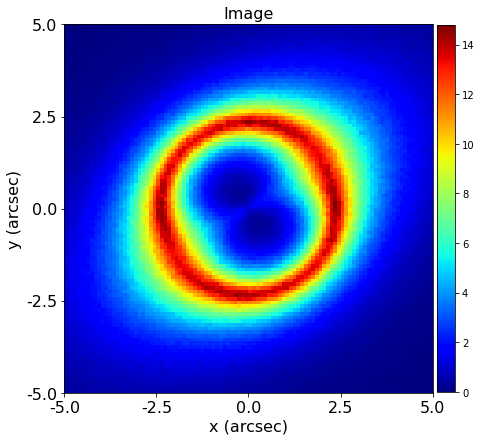

In [99]:
aplt.Imaging.image(imaging=imaging)

Finally, lets output these files to.fits files, we’ll begin to analyze them in the next tutorial!

The data path specifies where the data is output, this time in the directory ‘PointMass2/Data’.

Recall that we use the library pyprojroot to get a relative path to the autolens_workspace, double check this path is correct on your computer!

Setup the path to the autolens workspace, using the project pyprojroot which determines it automatically.

In [100]:
from pyprojroot import here

workspace_path = str(here())
dataset_path = f"{workspace_path}/howtolens/PointMass2/Data"
print("Dataset Path: ", dataset_path)

Dataset Path:  /home/carlos/autolens_workspace/howtolens/PointMass2/Data


In [101]:
imaging.output_to_fits(
    image_path=f"{dataset_path}/MGEimage.fits",
    noise_map_path=f"{dataset_path}/MGEnoise_map.fits",
    psf_path=f"{dataset_path}/MGEpsf.fits",
    overwrite=True,
)